In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns
import random
import math 
import psycopg2
import sys
sys.path.append('/mnt/ExtraDrive1/SafeBound/Source')
from SafeBoundUtils import *
from DBConnectionUtils import *
from SQLParser import * 
from PiecewiseConstantFunctionUtils import *

title = pd.read_csv("../Data/IMDB/title.csv", quotechar = "\"", escapechar="\\",
                       names=["id", "title", "imdb_index", "kind_id", "production_year", "imdb_id",
                              "phonetic_code", "episode_of_id", "season_nr", "episode_nr", "series_years", "md5sum"], low_memory=False)

company_name = pd.read_csv("../Data/IMDB/company_name.csv", quotechar = "\"", escapechar="\\",
                           names=["id", "name", "country_code", "imdb_id", "name_pcode_nf", "name_pcode_sf", "md5sum"], low_memory=False)
movie_companies = pd.read_csv("../Data/IMDB/movie_companies.csv", quotechar = "\"", escapechar="\\",
                           names=["id", "movie_id", "company_id", "company_type_id", "note"], low_memory=False)
movie_companies_full = movie_companies.merge(company_name, left_on="company_id", right_on="id").merge(title, left_on="movie_id", right_on="id")

In [17]:
table = movie_companies_full
tableName = "movie_companies_full"
joinCol = "production_year"
filterCol = "company_id"
numValuesToKeep = min(200, len(table[filterCol].value_counts(ascending=False)))
tableDFs = [table]
tableNames= [tableName]
tableJoinCols = [[joinCol]]
relativeErrorPerSegment = .01
originalFilterCols = [[filterCol]]
table = table[~table[filterCol].isna()]
table = table[~table[joinCol].isna()]
valuesOfScores = table[filterCol].value_counts(ascending=False).head(numValuesToKeep).index
numGroupChoices = [4, 8, 16, 32, 64]
selfJoinErrorsPerGroupsSingle = []
selfJoinErrorsPerGroupsComplete = []
selfJoinErrorsPerGroupsNaive = []
trueSelfJoinSize = []

for value in valuesOfScores:
    trueSelfJoinSize.append(sum([x**2 for x  in table[table[filterCol]==value][joinCol].value_counts()]))

for numGroups in numGroupChoices:    
    safeBoundStatsSingle = SafeBound(tableDFs, tableNames, tableJoinCols, relativeErrorPerSegment, originalFilterCols = originalFilterCols, 
                                numBuckets = 0, numEqualityOutliers=numValuesToKeep, FKtoKDict = dict(),
                                numOutliers = numGroups, trackNulls=False, trackTriGrams=False, numCores=12, 
                                groupingMethod="SingleClustering", verbose=False)    
    safeBoundStatsComplete = SafeBound(tableDFs, tableNames, tableJoinCols, relativeErrorPerSegment, originalFilterCols = originalFilterCols, 
                                numBuckets = 0, numEqualityOutliers=numValuesToKeep, FKtoKDict = dict(),
                                numOutliers = numGroups, trackNulls=False, trackTriGrams=False, numCores=12,
                                groupingMethod="CompleteClustering",  verbose=False)    
    safeBoundStatsNaive = SafeBound(tableDFs, tableNames, tableJoinCols, relativeErrorPerSegment, originalFilterCols = originalFilterCols, 
                                numBuckets = 0, numEqualityOutliers=numValuesToKeep, FKtoKDict = dict(),
                                numOutliers = numGroups, trackNulls=False, trackTriGrams=False, numCores=12,
                                groupingMethod="Naive",  verbose=False)
    
    
    selfJoinErrorsSingle = []
    selfJoinErrorsComplete = []
    selfJoinErrorsNaive = []
    for i, value in enumerate(valuesOfScores):
        queryGraph = JoinQueryGraph()
        queryGraph.addAlias(tableName, "p1")
        queryGraph.addAlias(tableName, "p2")
        queryGraph.addJoin("p1", joinCol, "p2", joinCol)
        queryGraph.addPredicate("p1", filterCol, "=", value)
        queryGraph.addPredicate("p2", filterCol, "=", value)
        queryGraph.buildJoinGraph()
        
        estimatedJoinSizeSingle = safeBoundStatsSingle.functionalFrequencyBound(queryGraph)
        estimatedJoinSizeComplete = safeBoundStatsComplete.functionalFrequencyBound(queryGraph)
        estimatedJoinSizeNaive = safeBoundStatsNaive.functionalFrequencyBound(queryGraph)
        
        selfJoinErrorsSingle.append(estimatedJoinSizeSingle / trueSelfJoinSize[i])
        selfJoinErrorsComplete.append(estimatedJoinSizeComplete / trueSelfJoinSize[i])
        selfJoinErrorsNaive.append(estimatedJoinSizeNaive / trueSelfJoinSize[i])
    selfJoinErrorsPerGroupsSingle.append(selfJoinErrorsSingle)
    selfJoinErrorsPerGroupsComplete.append(selfJoinErrorsComplete)
    selfJoinErrorsPerGroupsNaive.append(selfJoinErrorsNaive)

In [18]:
averageSelfJoinErrorsPerGroupsSingle = [sum(errors)/len(errors) for errors in selfJoinErrorsPerGroupsSingle]
averageSelfJoinErrorsPerGroupsComplete= [sum(errors)/len(errors) for errors in selfJoinErrorsPerGroupsComplete]
averageSelfJoinErrorsPerGroupsNaive= [sum(errors)/len(errors) for errors in selfJoinErrorsPerGroupsNaive]
compressionRatio = [numValuesToKeep/numGroups for numGroups in numGroupChoices]

In [19]:
[min(x) for x in selfJoinErrorsPerGroupsComplete]

[2.4387583767254104,
 2.249008828513605,
 1.4377472556317235,
 1.4377472556317235,
 1.2711758534698545]

In [20]:
averageSelfJoinErrorsPerGroupsSingle

[113.49840991590854,
 34.315447541062376,
 16.482491909960576,
 7.512187322112539,
 6.678617108908029]

In [21]:
averageSelfJoinErrorsPerGroupsComplete

[10.636381610419033,
 7.736709446561994,
 6.8622315771829845,
 6.790743284718433,
 6.3796487918397]

In [22]:
averageSelfJoinErrorsPerGroupsNaive

[59.49837593584591,
 21.005289955160254,
 10.174459834973385,
 7.595708256952927,
 6.689914772017292]

[None,
 None,
 Text(0, 0.5, 'Average Self-Join Error'),
 Text(0.5, 0, 'Compression Ratio'),
 (4, 200)]

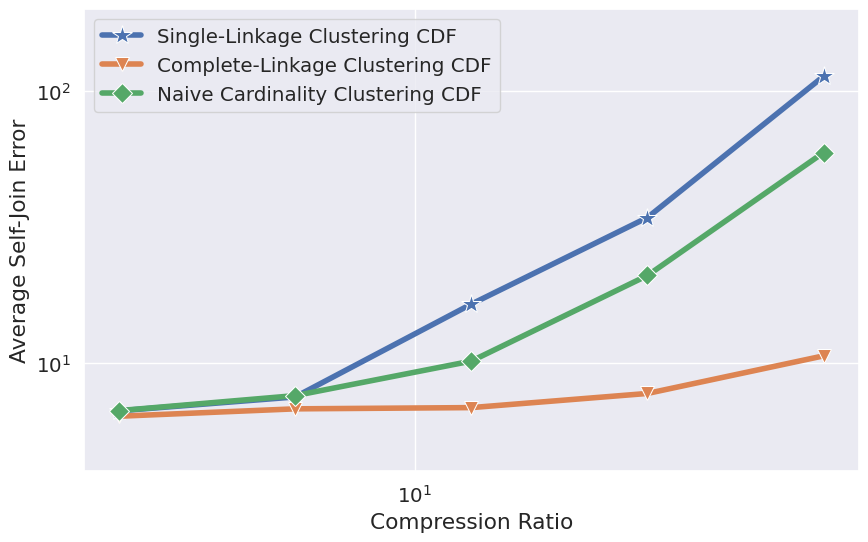

In [24]:
sns.set(rc={'figure.figsize':(10,6)})
sns.set_style("whitegrid")
sns.set_color_codes("pastel")
sns.set(font_scale = 1.3)
lineplot = sns.lineplot(x = compressionRatio, y = averageSelfJoinErrorsPerGroupsSingle, color = "C0", linewidth=4,linestyle="-", marker="*", markersize=15, label="Single-Linkage Clustering CDF")
lineplot = sns.lineplot(x = compressionRatio, y = averageSelfJoinErrorsPerGroupsComplete, color = "C1", linewidth=4,linestyle="-", marker="v", markersize=10, label="Complete-Linkage Clustering CDF")
lineplot = sns.lineplot(x = compressionRatio, y = averageSelfJoinErrorsPerGroupsNaive, color = "C2", linewidth=4,linestyle="-", marker="D", markersize=10, label="Naive Cardinality Clustering CDF")
lineplot.set(yscale='log', xscale='log', ylabel='Average Self-Join Error', xlabel="Compression Ratio", ylim=[4,200])

In [62]:
table = movie_companies_full
tableName = "title"
joinCol = "movie_id"
relativeErrorThreshold = [.2, .1, .05, .0125, .005, .001, .0005]
numSegmentsExponential = [2, 5, 10, 20, 40, 80, 100]
numSegmentsLinear = [2, 75, 100, 200, 400, 800, 1600]
perfectApproxSize = table[joinCol].value_counts().nunique()
degreeSequence = np.array(table[joinCol].value_counts(ascending=False).to_list(), dtype=np.int64)
selfJoinSize = sum([x**2 for x in degreeSequence])
exponentialErrors = []
linearErrors = []
relativeErrorErrors = []
exponentialSegments = []
linearSegments = []
relativeErrorSegments = []
exponentialErrorsPDF = []
linearErrorsPDF = []
relativeErrorErrorsPDF = []
exponentialSegmentsPDF = []
linearSegmentsPDF = []
relativeErrorSegmentsPDF = []
for i in range(len(relativeErrorThreshold)):
    functionExponential = PiecewiseConstantFunction(degreeSequence, numSegmentsExponential[i], "Exponential")
    selfJoinExponential = functionExponential.getSelfJoinSize()
    exponentialErrors.append(selfJoinExponential/selfJoinSize)
    exponentialSegments.append(perfectApproxSize/len(functionExponential.constants))
    functionLinear = PiecewiseConstantFunction(degreeSequence, numSegmentsLinear[i], "Linear")
    selfJoinLinear = functionLinear.getSelfJoinSize()
    linearSegments.append(perfectApproxSize/len(functionLinear.constants))
    linearErrors.append(selfJoinLinear/selfJoinSize)
    functionRelativeError = PiecewiseConstantFunction(degreeSequence, relativeErrorThreshold[i], "RelativeError")
    selfJoinRelativeError = functionRelativeError.getSelfJoinSize()
    relativeErrorErrors.append(selfJoinRelativeError/selfJoinSize)    
    relativeErrorSegments.append(perfectApproxSize/len(functionRelativeError.constants))
    
    functionExponential = PiecewiseConstantFunction(degreeSequence, numSegmentsExponential[i], "Exponential", False)
    selfJoinExponential = functionExponential.getSelfJoinSize()
    exponentialErrorsPDF.append(selfJoinExponential/selfJoinSize)
    exponentialSegmentsPDF.append(perfectApproxSize/len(functionExponential.constants))
    functionLinear = PiecewiseConstantFunction(degreeSequence, numSegmentsLinear[i], "Linear", False)
    selfJoinLinear = functionLinear.getSelfJoinSize()
    linearSegmentsPDF.append(perfectApproxSize/len(functionLinear.constants))
    linearErrorsPDF.append(selfJoinLinear/selfJoinSize)
    functionRelativeError = PiecewiseConstantFunction(degreeSequence, relativeErrorThreshold[i], "RelativeError", False)
    selfJoinRelativeError = functionRelativeError.getSelfJoinSize()
    relativeErrorErrorsPDF.append(selfJoinRelativeError/selfJoinSize)    
    relativeErrorSegmentsPDF.append(perfectApproxSize/len(functionRelativeError.constants))

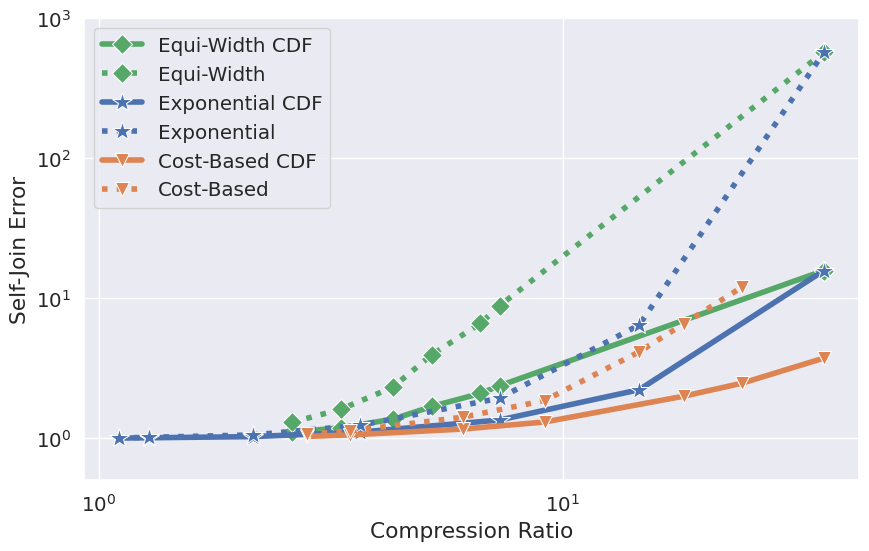

In [63]:
sns.set(rc={'figure.figsize':(10,6)})
sns.set_style("whitegrid")
sns.set_color_codes("pastel")
sns.set(font_scale = 1.3)
lineplot = sns.lineplot(x = linearSegments, y = linearErrors, color = "C2", linewidth=4,linestyle="-", marker="D", markersize=10, label="Equi-Width CDF")
lineplot = sns.lineplot(x = linearSegmentsPDF, y = linearErrorsPDF, color = "C2", linewidth=4,linestyle=":", marker="D", markersize=10, label="Equi-Width")
lineplot = sns.lineplot(x = exponentialSegments, y = exponentialErrors, color = "C0", linewidth=4,linestyle="-", marker="*", markersize=15, label="Exponential CDF")
lineplot = sns.lineplot(x = exponentialSegmentsPDF, y = exponentialErrorsPDF, color = "C0", linewidth=4,linestyle=":", marker="*", markersize=15, label="Exponential")
lineplot = sns.lineplot(x = relativeErrorSegments, y = relativeErrorErrors, color = "C1", linewidth=4,linestyle="-", marker="v", markersize=10, label="Cost-Based CDF")
lineplot = sns.lineplot(x = relativeErrorSegmentsPDF, y = relativeErrorErrorsPDF, color = "C1", linewidth=4,linestyle=":", marker="v", markersize=10, label="Cost-Based")
lineplot.set(yscale='log', xscale='log', ylabel='Self-Join Error', xlabel="Compression Ratio", ylim=[.5, 1000])
plt.show()